In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
from scipy.fftpack import dct
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import normalize
import sys
sys.path.append('..')
from src.group_classes import determine_genres
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) +
                           cycler('linestyle', ['-', '--', ':', '-.'])))

In [3]:
def get_cumulative_mi(X, y):
    mi = mutual_info_classif(X, y)
    return np.cumsum(mi)

<IPython.core.display.Javascript object>


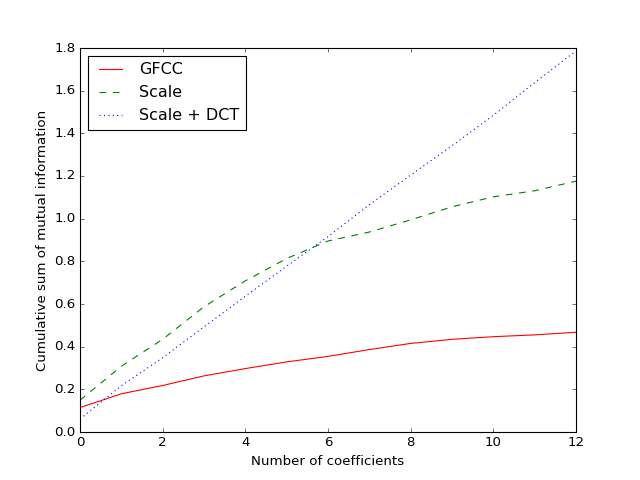

In [9]:
genres = determine_genres(write_to='../out/homburg_genres.json')
y = []
y_gfcc = []

with h5py.File('../out/homburg.h5', 'r') as f:
    X = []
    X_gfcc = []
    for t_name in f.keys():
        t_genre = genres[t_name]
        t = f[t_name]
        X.append(np.mean(np.abs(t['scale'].value), axis=0))
        X_gfcc.append(t['lowlevel.gfcc'].value)
        y.append(t_genre)
        y_gfcc.extend([t_genre] * t['lowlevel.gfcc'].shape[0])
X = np.vstack(X)
X_gfcc = np.vstack(X_gfcc)

X_dct = []
for row in X:
    row = dct(row, type=2, norm='ortho')
    X_dct.append(row)
X_dct = np.vstack(X_dct)

# pca = PCA(whiten=True)
# X_whitened = pca.fit_transform(X)

X_dct_div_max = np.asarray([row / np.amax(row) for row in X_dct])

infos = {}
infos['Scale'] = get_cumulative_mi(X, y)
infos['Scale + DCT'] = get_cumulative_mi(X_dct, y)
infos['GFCC'] = get_cumulative_mi(X_gfcc, y_gfcc)
# infos['DCT_sum1'] = get_cumulative_mi(normalize(X_dct, norm='l1'), y)
# infos['DCT_div_max'] = get_cumulative_mi(X_dct_div_max, y)
# infos['PCA'] = get_cumulative_mi(X_whitened, y)

plt.xlabel("Number of coefficients")
plt.ylabel("Cumulative sum of mutual information")
for k, mi in infos.iteritems():
    plt.plot(mi[:13], label=k)
plt.legend(loc='upper left')